## Acquisition Analytics : Bank Marketing

The objective is to reduce the customer acquisition cost by targeting the ones who are likely to buy and to improve the response rate, i.e. the fraction of prospects who respond to the campaign.

### Data Understanding:

In [1]:
# import warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"]= (5, 5)

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [3]:
#data loading
loan = pd.read_csv("bank_marketing.csv", sep=",")
loan.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
loan.shape

(41188, 21)

We have around 41K records with 21 columns.

In [5]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
response          41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

Target variable is response.

In [6]:
loan.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
response          0
dtype: int64

There is no null value.

In [7]:
# Looking at all the column names
loan.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'response'],
      dtype='object')

In [8]:
loan['response'].value_counts()

no     36548
yes     4640
Name: response, dtype: int64

As we note that the response variable has 'yes' and 'no' responses, we will convert it to 1 and 0 respectively

In [9]:
loan['response'] = loan['response'].map({'yes': 1, 'no': 0})

In [10]:
#rechecking the datatype of response variable
loan['response'].dtype

dtype('int64')

In [11]:
loan['response'].head()

0    0
1    0
2    0
3    0
4    0
Name: response, dtype: int64

In [12]:
loan['response'].value_counts()

0    36548
1     4640
Name: response, dtype: int64

In [13]:
# Copy the dataset into a back up dataframe for future use
loan_copy = loan

In [14]:
# Determine the percentage of people who have bought the investment product, that is those who have the response varibale as 1
100*(loan['response'].sum()/loan['response'].count()).round(4)

11.27

### Exploratory Data Analysis

Now, we will do Exploratory Data Analysis on individual features and look for patterns.

First, we will look at the client data.

- Age
- Job : type of job
- Marital : marital status
- Education
- Default: has credit in default?
- Housing: has housing loan?
- Loan: has personal loan?

#### Age

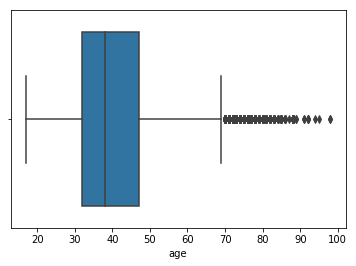

In [15]:
sns.boxplot(x='age', data=loan)
plt.show()

In [16]:
# Since there are a fair few data entries with age > 71, we will club all of those ages at 71 (since we can assume 
# that the behaviour will not change significantly with age at age above 70)
loan['age'][loan['age']>71] =71

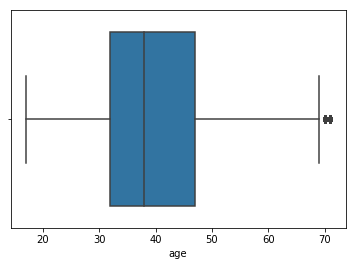

In [17]:
sns.boxplot(x='age', data=loan)
plt.show()

In [18]:
# To understand the behaviour of people with age, we are going to bucket the age groups into brackets of 10 and 
# study the response rates
bins = np.arange(10,loan['age'].max() + 10, 10)
loan['age_bins'] = pd.cut(loan['age'], bins, include_lowest=True)

In [19]:
No_of_prospect = loan.groupby('age_bins')['response'].count().reset_index(name = 'No.of_prospect')
count_prospects = loan[loan['response']==1].groupby('age_bins')['response'].count().reset_index(name = 'count_prospects')
agg_age = No_of_prospect.merge(count_prospects, on='age_bins')
agg_age

,age_bins,No.of_prospect,count_prospects
0,"(9.999, 20.0]",140,57
1,"(20.0, 30.0]",7243,1067
2,"(30.0, 40.0]",16385,1597
3,"(40.0, 50.0]",10240,837
4,"(50.0, 60.0]",6270,668
5,"(60.0, 70.0]",488,212
6,"(70.0, 80.0]",422,202


In [20]:
agg_age['response_rate'] = 100*(agg_age['count_prospects']/agg_age['No.of_prospect']).round(3)
agg_age

,age_bins,No.of_prospect,count_prospects,response_rate
0,"(9.999, 20.0]",140,57,40.7
1,"(20.0, 30.0]",7243,1067,14.7
2,"(30.0, 40.0]",16385,1597,9.7
3,"(40.0, 50.0]",10240,837,8.2
4,"(50.0, 60.0]",6270,668,10.7
5,"(60.0, 70.0]",488,212,43.4
6,"(70.0, 80.0]",422,202,47.9


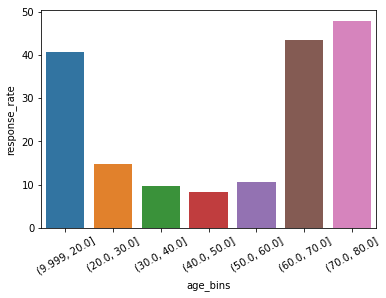

In [21]:
ax = sns.barplot(x='age_bins', y='response_rate', data=agg_age)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

As we can see, the youngest and the eldest are the most likely to buy the investment product being offered by the bank.
Also,it is important to note that there is a huge difference in the volume of data entries in these categories.

Similarly, let us look at the relation between response rate and job.

#### Job

In [22]:
loan['job'].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [23]:
count_prospects_job = loan.groupby('job')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_job = loan.groupby('job')['response'].count().reset_index(name = 'No_of_prospects')
agg_job = count_prospects_job.merge(No_of_prospect_job, on = 'job')
agg_job['response_rate'] = 100*(agg_job['count_prospects']/agg_job['No_of_prospects']).round(4)
agg_job

,job,count_prospects,No_of_prospects,response_rate
0,admin.,1352,10422,12.97
1,blue-collar,638,9254,6.89
2,entrepreneur,124,1456,8.52
3,housemaid,106,1060,10.00
4,management,328,2924,11.22
5,retired,434,1720,25.23
6,self-employed,149,1421,10.49
7,services,323,3969,8.14
8,student,275,875,31.43
9,technician,730,6743,10.83


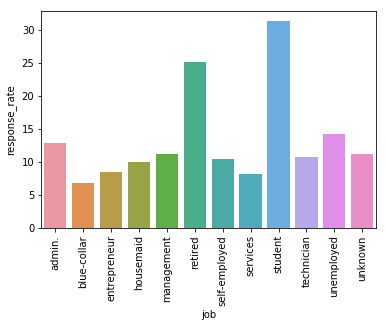

In [24]:
ax = sns.barplot(x='job', y='response_rate', data=agg_job)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

We can draw similarities from the age response analysis where we found that the youngest and eldest were most likely to respond in a positive manner. It is reiterated by the above analysis, where we notice that student and retired have the highest response rates.

#### Marital

In [25]:
loan['marital'].value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

Since there are 80 entries which list marital status as 'unknown', we will assign them to the biggest group, which is, 'married'.

In [26]:
loan.replace({'marital' : { 'unknown' : 'married'}}, inplace=True)
count_prospects_marital = loan.groupby('marital')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_job = loan.groupby('marital')['response'].count().reset_index(name = 'No_of_prospects')
agg_marital = count_prospects_marital.merge(No_of_prospect_job, on = 'marital')
agg_marital['response_rate'] = 100*(agg_marital['count_prospects']/agg_marital['No_of_prospects']).round(4)
agg_marital

,marital,count_prospects,No_of_prospects,response_rate
0,divorced,476,4612,10.32
1,married,2544,25008,10.17
2,single,1620,11568,14.00


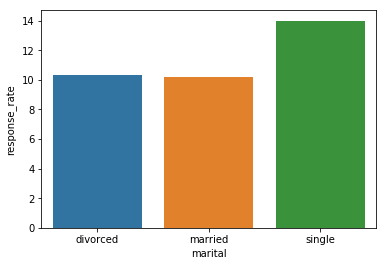

In [27]:
ax = sns.barplot(x='marital', y='response_rate', data=agg_marital)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

We note that there is a slight uptick in response rate for single customers, this can be attributed in part to the fact that people under the age of 20 have a very high response rate. 

#### Education

In [28]:
loan['education'].value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

To simplify the problem, we are going to convert the educational qualifications to simple buckets of primary educations, secondary education, tertiary education and professional courses. Also note that there are 18 entries listing the educational status as illiterate. Since the closest group to them is primary education, we are going to assign all entries with educational status as illiterate to primary education.

In [29]:
loan.replace({'education' : { 'basic.9y' : 'Primary_Education', 'basic.4y' : 'Primary_Education','basic.6y' : 'Primary_Education','illiterate' : 'Primary_Education',
                             'high.school' : 'Secondary_Education', 'university.degree' : 'Tertiary_Education' }}, inplace=True)

In [30]:
loan['education'].value_counts()

Primary_Education      12531
Tertiary_Education     12168
Secondary_Education     9515
professional.course     5243
unknown                 1731
Name: education, dtype: int64

In [31]:
count_prospects_education = loan.groupby('education')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_education = loan.groupby('education')['response'].count().reset_index(name = 'No_of_prospects')
agg_education = count_prospects_education.merge(No_of_prospect_education, on = 'education')
agg_education['response_rate'] = 100*(agg_education['count_prospects']/agg_education['No_of_prospects']).round(4)
agg_education

,education,count_prospects,No_of_prospects,response_rate
0,Primary_Education,1093,12531,8.72
1,Secondary_Education,1031,9515,10.84
2,Tertiary_Education,1670,12168,13.72
3,professional.course,595,5243,11.35
4,unknown,251,1731,14.50


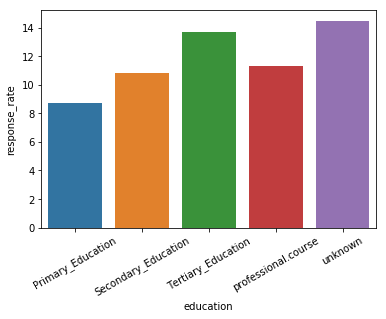

In [32]:
ax = sns.barplot(x='education', y='response_rate', data=agg_education)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

We note that the response rate is lowest for people with highest education qualification as primary education, which may be attributed, in part, to lack of awareness and a lack of trust between the bank and the customer. It is the highest for people with tertiary education.

#### Previous Default

In [33]:
loan['default'].value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

In [34]:
count_prospects_default = loan.groupby('default')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_default = loan.groupby('default')['response'].count().reset_index(name = 'No_of_prospects')
agg_default = count_prospects_default.merge(No_of_prospect_default, on = 'default')
agg_default['response_rate'] = 100*(agg_default['count_prospects']/agg_default['No_of_prospects']).round(4)
agg_default

,default,count_prospects,No_of_prospects,response_rate
0,no,4197,32588,12.88
1,unknown,443,8597,5.15
2,yes,0,3,0.00


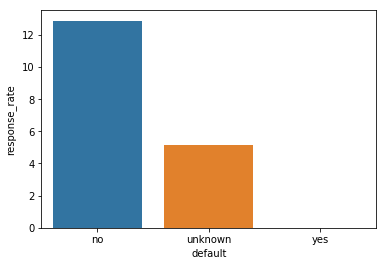

In [35]:
ax = sns.barplot(x='default', y='response_rate', data=agg_default)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

#### Housing

In [36]:
loan['housing'].value_counts()

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

In [37]:
count_prospects_housing = loan.groupby('housing')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_housing = loan.groupby('housing')['response'].count().reset_index(name = 'No_of_prospects')
agg_housing = count_prospects_housing.merge(No_of_prospect_housing, on = 'housing')
agg_housing['response_rate'] = 100*(agg_housing['count_prospects']/agg_housing['No_of_prospects']).round(4)
agg_housing

,housing,count_prospects,No_of_prospects,response_rate
0,no,2026,18622,10.88
1,unknown,107,990,10.81
2,yes,2507,21576,11.62


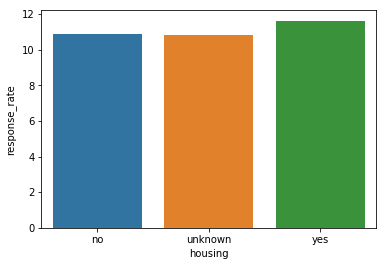

In [38]:
ax = sns.barplot(x='housing', y='response_rate', data=agg_housing)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

We see that there is a slight uptick in the response rate for people with housing, though it is probably not very significant

#### Loan

In [39]:
loan['loan'].value_counts()

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

In [40]:
count_prospects_loan = loan.groupby('loan')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_loan = loan.groupby('loan')['response'].count().reset_index(name = 'No_of_prospects')
agg_loan = count_prospects_loan.merge(No_of_prospect_loan, on = 'loan')
agg_loan['response_rate'] = 100*(agg_loan['count_prospects']/agg_loan['No_of_prospects']).round(4)
agg_loan

,loan,count_prospects,No_of_prospects,response_rate
0,no,3850,33950,11.34
1,unknown,107,990,10.81
2,yes,683,6248,10.93


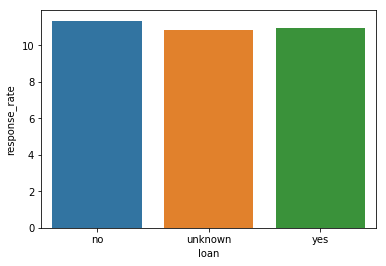

In [41]:
ax = sns.barplot(x='loan', y='response_rate', data=agg_loan)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

We see that there seems to be very little correlation between a prospect having a personal loan and the likelihood of him/her responding positively to the investment product

Now that we have had a look at the client data, we will move to the last contact information.

There are four features in the given dataset which cover this information.

- Contact: contact communication type
- Month: last contact month of year
- Day_of_week: last contact day of the week
- Duration: last contact duration, in seconds 

#### Contact

In [42]:
loan['contact'].value_counts()

cellular     26144
telephone    15044
Name: contact, dtype: int64

In [43]:
count_prospects_contact = loan.groupby('contact')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_contact = loan.groupby('contact')['response'].count().reset_index(name = 'No_of_prospects')
agg_contact = count_prospects_contact.merge(No_of_prospect_contact, on = 'contact')
agg_contact['response_rate'] = 100*(agg_contact['count_prospects']/agg_contact['No_of_prospects']).round(4)
agg_contact

,contact,count_prospects,No_of_prospects,response_rate
0,cellular,3853,26144,14.74
1,telephone,787,15044,5.23


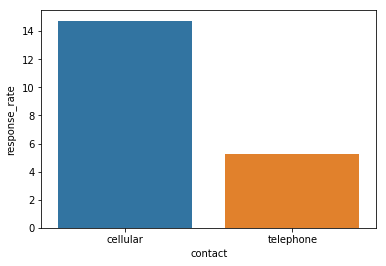

In [44]:
ax = sns.barplot(x='contact', y='response_rate', data=agg_contact)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

We see that the prospective customers contacted through cellular medium are significantly or likely to opt in to the investment scheme compared to customers contacted through telephonic medium.

#### Month

In [45]:
loan['month'].value_counts()

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64

In [46]:
count_prospects_month = loan.groupby('month')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_month = loan.groupby('month')['response'].count().reset_index(name = 'No_of_prospects')
agg_month = count_prospects_month.merge(No_of_prospect_month, on = 'month')
agg_month['response_rate'] = 100*(agg_month['count_prospects']/agg_month['No_of_prospects']).round(4)
agg_month

,month,count_prospects,No_of_prospects,response_rate
0,apr,539,2632,20.48
1,aug,655,6178,10.60
2,dec,89,182,48.90
3,jul,649,7174,9.05
4,jun,559,5318,10.51
5,mar,276,546,50.55
6,may,886,13769,6.43
7,nov,416,4101,10.14
8,oct,315,718,43.87
9,sep,256,570,44.91


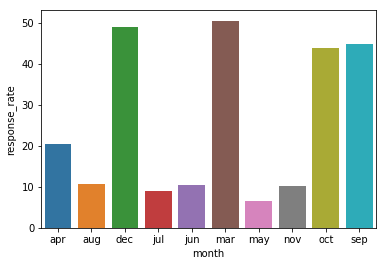

In [47]:
ax = sns.barplot(x='month', y='response_rate', data=agg_month)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

We note that the four months of december, march, october and september appear to be the best to contact the potential customers. However, these months have the fewest data entries as well, so it is not certain, how well it would behave when calls are made at a high volume.

#### Day of the week

In [48]:
loan['day_of_week'].value_counts()

thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64

In [49]:
count_prospects_day = loan.groupby('day_of_week')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_day = loan.groupby('day_of_week')['response'].count().reset_index(name = 'No_of_prospects')
agg_day = count_prospects_day.merge(No_of_prospect_day, on = 'day_of_week')
agg_day['response_rate'] = 100*(agg_day['count_prospects']/agg_day['No_of_prospects']).round(4)
agg_day

,day_of_week,count_prospects,No_of_prospects,response_rate
0,fri,846,7827,10.81
1,mon,847,8514,9.95
2,thu,1045,8623,12.12
3,tue,953,8090,11.78
4,wed,949,8134,11.67


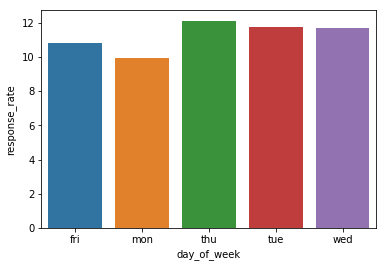

In [50]:
ax = sns.barplot(x='day_of_week', y='response_rate', data=agg_day)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

We see that response rate is lowest on monday, while being highest on thursday. However, the gap isn't very big.

#### Duration of the call

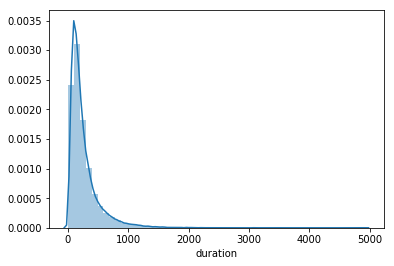

In [51]:
sns.distplot(loan['duration'])
plt.show()

As we know that this is a continuos variable, we will create a box plot

In [52]:
loan['duration'].describe(percentiles = [0.25,0.50,0.75,0.95,0.99])

count    41188.000000
mean       258.285010
std        259.279249
min          0.000000
25%        102.000000
50%        180.000000
75%        319.000000
95%        752.650000
99%       1271.130000
max       4918.000000
Name: duration, dtype: float64

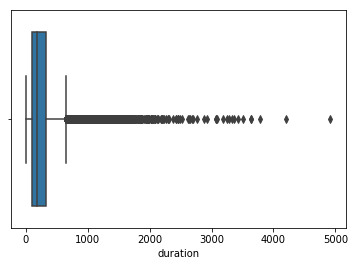

In [53]:
sns.boxplot(x='duration', data=loan)
plt.show()

Since less than one percent of entires have duration greater than 1271, we can assume all entries with duration greater than 1271 as having duration as 1271.

In [54]:
loan['duration'][loan['duration']>1271] =1271

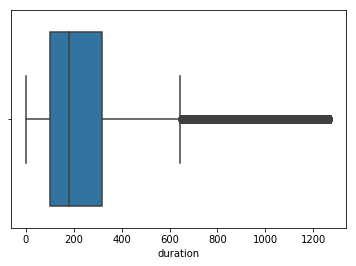

In [55]:
sns.boxplot(x='duration', data=loan)
plt.show()

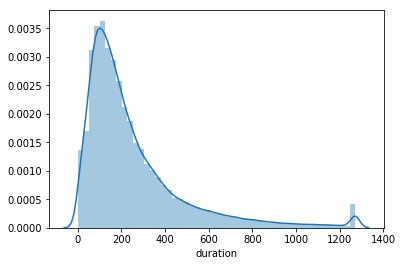

In [56]:
sns.distplot(loan['duration'])
plt.show()

Now that we have looked at client data and the data related to last contact, we will look at some of the other attributes.

- Campaign: number of contacts performed during this campaign and for this client
- Pdays: number of days that passed by after the client was last contacted from a previous campaign
- Previous: number of contacts performed before this campaign and for this client
- Poutcome: outcome of the previous marketing campaign

#### Campaign

In [57]:
loan['campaign'].value_counts()

1     17642
2     10570
3      5341
4      2651
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
15       51
16       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
25        8
26        8
28        8
30        7
31        7
35        5
33        4
32        4
34        3
40        2
42        2
43        2
37        1
39        1
41        1
56        1
Name: campaign, dtype: int64

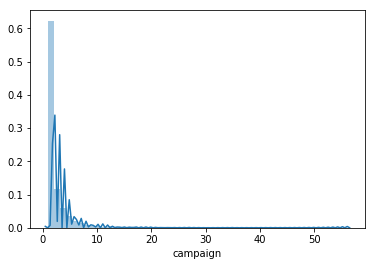

In [58]:
sns.distplot(loan['campaign'])
plt.show()

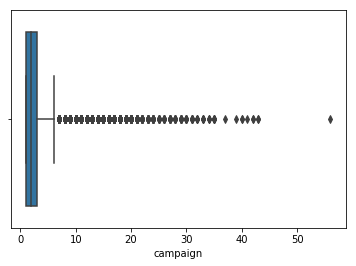

In [59]:
# We will create a box plot
sns.boxplot(x='campaign', data=loan)
plt.show()

In [60]:
loan['campaign'].describe(percentiles = [0.25,0.50,0.75,0.95,0.99])

count    41188.000000
mean         2.567593
std          2.770014
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
95%          7.000000
99%         14.000000
max         56.000000
Name: campaign, dtype: float64

Once again, we can merga all data entries with contacts greater than 14 as having campaign contact as 14

In [61]:
loan['campaign'][loan['campaign']>14] =14

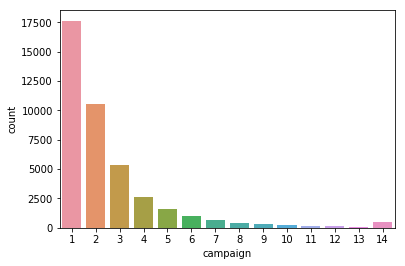

In [62]:
sns.countplot(loan['campaign'])
plt.show()

In [63]:
count_prospects_campaign = loan.groupby('campaign')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_campaign = loan.groupby('campaign')['response'].count().reset_index(name = 'No_of_prospects')
agg_campaign = count_prospects_campaign.merge(No_of_prospect_campaign, on = 'campaign')
agg_campaign['response_rate'] = 100*(agg_campaign['count_prospects']/agg_campaign['No_of_prospects']).round(4)
agg_campaign

,campaign,count_prospects,No_of_prospects,response_rate
0,1,2300,17642,13.04
1,2,1211,10570,11.46
2,3,574,5341,10.75
3,4,249,2651,9.39
4,5,120,1599,7.50
5,6,75,979,7.66
6,7,38,629,6.04
7,8,17,400,4.25
8,9,17,283,6.01
9,10,12,225,5.33


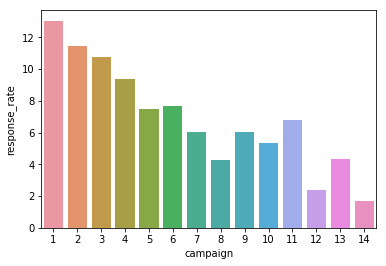

In [64]:
ax = sns.barplot(x='campaign', y='response_rate', data=agg_campaign)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

Interesting to note, that the response rate gradually decreases as the number of campaign contacts increases.

#### Gap after the last contact

In [65]:
loan['pdays'].value_counts()

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
19         3
22         3
21         2
26         1
20         1
25         1
27         1
Name: pdays, dtype: int64

We are going to divide the pdays into three buckets, that is contacted within the first ten days, contacted after first ten days and first time contacted. Note that the pdays value of 999 means client was not previously contacted.

In [66]:
loan['pdays'][loan['pdays'].isin([0,1,2,3,4,5,6,7,8,9,10])]='Contacted_in_first_10days'

loan['pdays'][loan['pdays'].isin([999])]='First_time_contacted'

loan['pdays'][~loan['pdays'].isin(['Contacted_in_first_10days','First_time_contacted'])]='Contacted_after_10days'

In [67]:
loan['pdays'].value_counts()

First_time_contacted         39673
Contacted_in_first_10days     1311
Contacted_after_10days         204
Name: pdays, dtype: int64

In [68]:
count_prospects_pdays = loan.groupby('pdays')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_pdays = loan.groupby('pdays')['response'].count().reset_index(name = 'No_of_prospects')
agg_pdays = count_prospects_pdays.merge(No_of_prospect_pdays, on = 'pdays')
agg_pdays['response_rate'] = 100*(agg_pdays['count_prospects']/agg_pdays['No_of_prospects']).round(4)
agg_pdays

,pdays,count_prospects,No_of_prospects,response_rate
0,Contacted_after_10days,116,204,56.86
1,Contacted_in_first_10days,851,1311,64.91
2,First_time_contacted,3673,39673,9.26


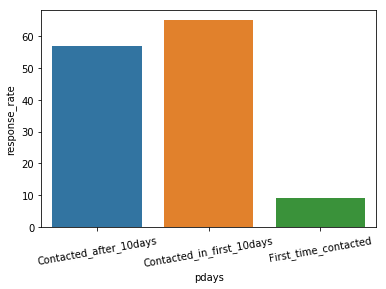

In [69]:
ax = sns.barplot(x='pdays', y='response_rate', data=agg_pdays)
ax.set_xticklabels(ax.get_xticklabels(),rotation=10)
plt.show()

Though there is a huge difference in the response rates of the three categories, it is important to note that there is also a huge difference in the volume of data entries in these categories

#### Previous

In [70]:
loan['previous'].value_counts()

0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64

Since the data ranges from 0 to 7, we are going to break it into three categories, that is never contacted, contacted less than three times and contacted greater than three times

In [71]:
loan['previous'][loan['previous'].isin([0])]='Never contacted'
loan['previous'][loan['previous'].isin([1,2,3])]='Less_than_3_times'
loan['previous'][loan['previous'].isin([4,5,6,7])]='More than_3_times'

In [72]:
loan['previous'].value_counts()

Never contacted      35563
Less_than_3_times     5531
More than_3_times       94
Name: previous, dtype: int64

In [73]:
count_prospects_previous = loan.groupby('previous')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_previous = loan.groupby('previous')['response'].count().reset_index(name = 'No_of_prospects')
agg_previous = count_prospects_previous.merge(No_of_prospect_previous, on = 'previous')
agg_previous['response_rate'] = 100*(agg_previous['count_prospects']/agg_previous['No_of_prospects']).round(4)
agg_previous

,previous,count_prospects,No_of_prospects,response_rate
0,Less_than_3_times,1445,5531,26.13
1,More than_3_times,54,94,57.45
2,Never contacted,3141,35563,8.83


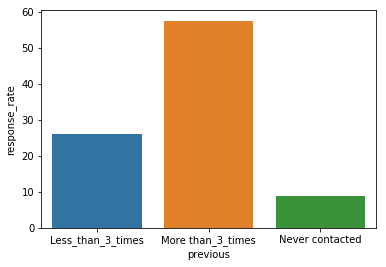

In [74]:
ax = sns.barplot(x='previous', y='response_rate', data=agg_previous)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

We can note that the response rate is greatest for the the potential customers having previous contact of more than three. However,the number of data entries is very low for such cases, hence it's difficult to draw any inferences.

Now that we have analysed all the client related information, we will move to the wider social and economic variables, which gives us a clue of the conditions when a client is more likely to buy the product.

- emp.var.rate: Employment Variation Rate - Quarterly Indicator
- cons.price.idx: Consumer Price Index - Monthly Indicator 
- cons.conf.idx: Consumer Confidence Index - Monthly Indicator 
- euribor3m: Euribor 3 Month Rate - Daily Indicator
- nr.employed: Number of Employees - Quarterly Indicator

#### Employment Variation Rate

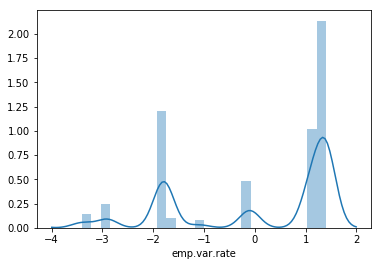

In [75]:
sns.distplot(loan['emp.var.rate'])
plt.show()

In [76]:
loan['emp.var.rate'].describe(percentiles = [0.25,0.50,0.75,0.95,0.99])

count    41188.000000
mean         0.081886
std          1.570960
min         -3.400000
25%         -1.800000
50%          1.100000
75%          1.400000
95%          1.400000
99%          1.400000
max          1.400000
Name: emp.var.rate, dtype: float64

In [77]:
loan['emp.var.rate'].value_counts()

 1.4    16234
-1.8     9184
 1.1     7763
-0.1     3683
-2.9     1663
-3.4     1071
-1.7      773
-1.1      635
-3.0      172
-0.2       10
Name: emp.var.rate, dtype: int64

In [78]:
count_prospects_emp_var_rate = loan.groupby('emp.var.rate')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_emp_var_rate = loan.groupby('emp.var.rate')['response'].count().reset_index(name = 'No_of_prospects')
agg_emp_var_rate = count_prospects_emp_var_rate.merge(No_of_prospect_emp_var_rate, on = 'emp.var.rate')
agg_emp_var_rate['response_rate'] = 100*(agg_emp_var_rate['count_prospects']/agg_emp_var_rate['No_of_prospects']).round(4)
agg_emp_var_rate

,emp.var.rate,count_prospects,No_of_prospects,response_rate
0,-3.4,454,1071,42.39
1,-3.0,88,172,51.16
2,-2.9,594,1663,35.72
3,-1.8,1461,9184,15.91
4,-1.7,403,773,52.13
5,-1.1,301,635,47.40
6,-0.2,1,10,10.00
7,-0.1,232,3683,6.30
8,1.1,240,7763,3.09
9,1.4,866,16234,5.33


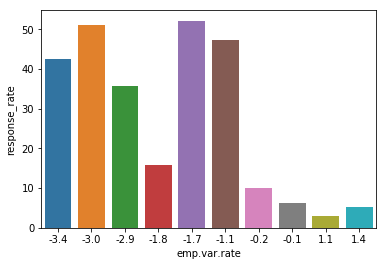

In [79]:
ax = sns.barplot(x='emp.var.rate', y='response_rate', data=agg_emp_var_rate)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

We note that a negative employment variation rate seems to be related to higher response rates.

#### Consumer Price Index

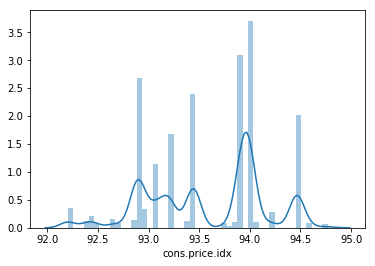

In [80]:
sns.distplot(loan['cons.price.idx'])
plt.show()

In [81]:
loan['cons.price.idx'].describe(percentiles = [0.25,0.50,0.75,0.95,0.99])

count    41188.000000
mean        93.575664
std          0.578840
min         92.201000
25%         93.075000
50%         93.749000
75%         93.994000
95%         94.465000
99%         94.465000
max         94.767000
Name: cons.price.idx, dtype: float64

In [82]:
loan['cons.conf.idx'].value_counts()

-36.4    7763
-42.7    6685
-46.2    5794
-36.1    5175
-41.8    4374
-42.0    3616
-47.1    2458
-31.4     770
-40.8     715
-26.9     447
-30.1     357
-40.3     311
-37.5     303
-50.0     282
-29.8     267
-34.8     264
-38.3     233
-39.8     229
-40.0     212
-49.5     204
-33.6     178
-34.6     174
-33.0     172
-50.8     128
-40.4      67
-45.9      10
Name: cons.conf.idx, dtype: int64

In [83]:
count_prospects_cons_price_idx = loan.groupby('cons.price.idx')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_cons_price_idx = loan.groupby('cons.price.idx')['response'].count().reset_index(name = 'No_of_prospects')
agg_cons_price_idx = count_prospects_cons_price_idx.merge(No_of_prospect_cons_price_idx, on = 'cons.price.idx')
agg_cons_price_idx['response_rate'] = 100*(agg_cons_price_idx['count_prospects']/agg_cons_price_idx['No_of_prospects']).round(4)

In [84]:
agg_cons_price_idx.sort_values(by= 'response_rate', ascending = False).head()

,cons.price.idx,count_prospects,No_of_prospects,response_rate
15,93.798,42,67,62.69
16,93.876,122,212,57.55
12,93.369,150,264,56.82
22,94.215,176,311,56.59
14,93.749,97,174,55.75


#### Euribor three month rate

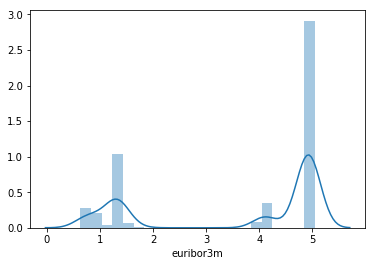

In [85]:
sns.distplot(loan['euribor3m'])
plt.show()

In [86]:
loan['euribor3m'].describe(percentiles = [0.25,0.50,0.75,0.95,0.99])

count    41188.000000
mean         3.621291
std          1.734447
min          0.634000
25%          1.344000
50%          4.857000
75%          4.961000
95%          4.966000
99%          4.968000
max          5.045000
Name: euribor3m, dtype: float64

In [87]:
count_prospects_euribor = loan.groupby('euribor3m')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_euribor = loan.groupby('euribor3m')['response'].count().reset_index(name = 'No_of_prospects')
agg_euribor = count_prospects_euribor.merge(No_of_prospect_euribor, on = 'euribor3m')
agg_euribor['response_rate'] = 100*(agg_euribor['count_prospects']/agg_euribor['No_of_prospects']).round(4)

In [88]:
agg_euribor.sort_values(by= 'response_rate', ascending = False).head()

,euribor3m,count_prospects,No_of_prospects,response_rate
255,3.053,1,1,100.00
28,0.688,3,3,100.00
148,0.933,1,1,100.00
117,0.870,12,13,92.31
128,0.885,9,10,90.00


#### Number of employeees

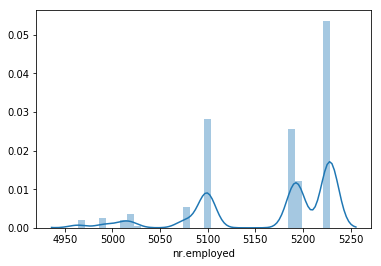

In [89]:
sns.distplot(loan['nr.employed'])
plt.show()

In [90]:
loan['nr.employed'].value_counts()

5228.1    16234
5099.1     8534
5191.0     7763
5195.8     3683
5076.2     1663
5017.5     1071
4991.6      773
5008.7      650
4963.6      635
5023.5      172
5176.3       10
Name: nr.employed, dtype: int64

In [91]:
loan['nr.employed'].describe(percentiles = [0.25,0.50,0.75,0.95,0.99])

count    41188.000000
mean      5167.035911
std         72.251528
min       4963.600000
25%       5099.100000
50%       5191.000000
75%       5228.100000
95%       5228.100000
99%       5228.100000
max       5228.100000
Name: nr.employed, dtype: float64

In [92]:
count_prospects_num_employed = loan.groupby('nr.employed')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_num_employed = loan.groupby('nr.employed')['response'].count().reset_index(name = 'No_of_prospects')
agg_num_employed = count_prospects_num_employed.merge(No_of_prospect_num_employed, on = 'nr.employed')
agg_num_employed['response_rate'] = 100*(agg_num_employed['count_prospects']/agg_euribor['No_of_prospects']).round(4)

In [93]:
agg_num_employed.sort_values(by= 'response_rate', ascending = False).head()

,nr.employed,count_prospects,No_of_prospects,response_rate
6,5099.1,1092,8534,10920.00
3,5017.5,454,1071,7566.67
0,4963.6,301,635,3762.50
5,5076.2,594,1663,3712.50
10,5228.1,866,16234,3330.77


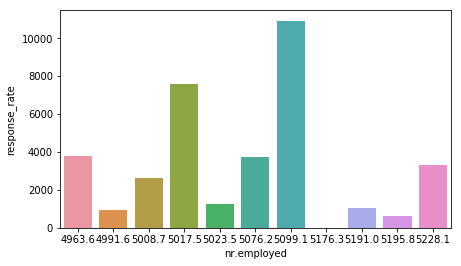

In [94]:
plt.figure(figsize = (7,4))
ax = sns.barplot(x='nr.employed', y='response_rate', data=agg_num_employed)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

Now that we have completed basic exploratory analysis, we can move to the next stage, that is data cleaning and data preparation

#### Data Preparation

In [95]:
# inspect the columns
loan.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'response', 'age_bins'],
      dtype='object')

In [96]:
# Droping the column age_bins we had created for the purpose of data visualisation
loan.drop(columns = 'age_bins', inplace = True)

In [97]:
#creating a unique ID for each prospect.
loan['prospect_id'] = range(1,len(loan)+1)
loan.set_index('prospect_id',inplace = True)

In [98]:
# Copy the dataset into a back up dataframe for future use
loan_copy1 = loan[:]

In [99]:
#Removing the "duration" column from the dataframe. 
# Since, the prospect data procured by the marketing team does not contain ‘duration’, since the call has not been made yet.
#And also because, as the duration increases, it increase the cost of telemarketing which is a concern for the organization. 
loan.drop(columns ='duration', inplace = True)

In [100]:
# Creating a dummy variable for the variable 'job' and dropping the first one.
job = pd.get_dummies(loan['job'],prefix='job',drop_first=True)

#Adding the results to the master dataframe
loan = pd.concat([loan,job],axis=1)

# Creating dummy variable for marital column
marital = pd.get_dummies(loan['marital'],prefix='marital',drop_first=True)
loan = pd.concat([loan,marital],axis=1)


# Creating dummy variable for education column
education = pd.get_dummies(loan['education'],prefix='education',drop_first=True)
loan = pd.concat([loan,education],axis=1)

# Creating dummy variable for default column
default = pd.get_dummies(loan['default'],prefix='default',drop_first=True)
loan = pd.concat([loan,default],axis=1)


# Creating dummy variable for housing column
housing = pd.get_dummies(loan['housing'],prefix='housing',drop_first=True)
loan = pd.concat([loan,housing],axis=1)

# Creating dummy variable for loan column
loan_v= pd.get_dummies(loan['loan'],prefix='loan',drop_first=True)
loan = pd.concat([loan,loan_v],axis=1)

# Creating dummy variable for contact column
contact = pd.get_dummies(loan['contact'],prefix='contact',drop_first=True)
loan = pd.concat([loan,contact],axis=1)

# Creating dummy variable for month column
month = pd.get_dummies(loan['month'],prefix='month',drop_first=True)
loan = pd.concat([loan,month],axis=1)

# Creating dummy variable for day_of_week column
day_of_week = pd.get_dummies(loan['day_of_week'],prefix='day_of_week',drop_first=True)
loan = pd.concat([loan,day_of_week],axis=1)

# Creating dummy variable for pdays column
pdays = pd.get_dummies(loan['pdays'],prefix='pdays',drop_first=True)
loan = pd.concat([loan,pdays],axis=1)

# Creating dummy variable for previous column
previous = pd.get_dummies(loan['previous'],prefix='previous',drop_first=True)
loan = pd.concat([loan,previous],axis=1)


# Creating dummy variable for poutcome column
poutcome = pd.get_dummies(loan['poutcome'],prefix='poutcome',drop_first=True)
loan = pd.concat([loan,poutcome],axis=1)

In [101]:
#ispecting the df
loan.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,pdays_Contacted_in_first_10days,pdays_First_time_contacted,previous_More than_3_times,previous_Never contacted,poutcome_nonexistent,poutcome_success
prospect_id,,,,,,,,,,,,,,,,,,,,,
1,56,housemaid,married,Primary_Education,no,no,no,telephone,may,mon,...,1,0,0,0,0,1,0,1,1,0
2,57,services,married,Secondary_Education,unknown,no,no,telephone,may,mon,...,1,0,0,0,0,1,0,1,1,0
3,37,services,married,Secondary_Education,no,yes,no,telephone,may,mon,...,1,0,0,0,0,1,0,1,1,0
4,40,admin.,married,Primary_Education,no,no,no,telephone,may,mon,...,1,0,0,0,0,1,0,1,1,0
5,56,services,married,Secondary_Education,no,no,yes,telephone,may,mon,...,1,0,0,0,0,1,0,1,1,0


In [102]:
# Drop all features for whom dummy variable has been created
loan.drop(columns = ['job','marital','education','default','housing','loan','contact','month','day_of_week','pdays','previous','poutcome'], inplace=True)

In [103]:
#rechecking the dataframe
loan.head()

,age,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response,job_blue-collar,job_entrepreneur,...,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,pdays_Contacted_in_first_10days,pdays_First_time_contacted,previous_More than_3_times,previous_Never contacted,poutcome_nonexistent,poutcome_success
prospect_id,,,,,,,,,,,,,,,,,,,,,
1,56,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,...,1,0,0,0,0,1,0,1,1,0
2,57,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,...,1,0,0,0,0,1,0,1,1,0
3,37,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,...,1,0,0,0,0,1,0,1,1,0
4,40,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,...,1,0,0,0,0,1,0,1,1,0
5,56,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,...,1,0,0,0,0,1,0,1,1,0


In [104]:
# let us check the info
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 1 to 41188
Data columns (total 51 columns):
age                                41188 non-null int64
campaign                           41188 non-null int64
emp.var.rate                       41188 non-null float64
cons.price.idx                     41188 non-null float64
cons.conf.idx                      41188 non-null float64
euribor3m                          41188 non-null float64
nr.employed                        41188 non-null float64
response                           41188 non-null int64
job_blue-collar                    41188 non-null uint8
job_entrepreneur                   41188 non-null uint8
job_housemaid                      41188 non-null uint8
job_management                     41188 non-null uint8
job_retired                        41188 non-null uint8
job_self-employed                  41188 non-null uint8
job_services                       41188 non-null uint8
job_student                        41188 

#### Model Building:

In [105]:
# Import library to split the dataset into test and train
from sklearn.model_selection import train_test_split

In [106]:
# Putting feature variable to X
X = loan.drop(['response'],axis=1)

# Putting response variable to y
y = loan['response']

In [107]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

#### Standardisation

In [108]:
X_train.head()

,age,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,...,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,pdays_Contacted_in_first_10days,pdays_First_time_contacted,previous_More than_3_times,previous_Never contacted,poutcome_nonexistent,poutcome_success
prospect_id,,,,,,,,,,,,,,,,,,,,,
7020,31,4,1.1,93.994,-36.4,4.860,5191.0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
27176,51,3,-0.1,93.200,-42.0,4.021,5195.8,0,0,0,...,0,0,0,0,0,1,0,1,1,0
15818,39,3,1.4,93.918,-42.7,4.960,5228.1,0,0,0,...,1,0,0,0,0,1,0,1,1,0
40972,68,4,-1.1,94.601,-49.5,1.000,4963.6,0,0,0,...,1,0,0,0,0,1,0,0,0,0
8468,37,3,1.4,94.465,-41.8,4.864,5228.1,0,0,0,...,0,0,1,0,0,1,0,1,1,0


In [109]:
# Standardisation continuous features for X_train
col_list = ['age','campaign','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

In [110]:
scaler = StandardScaler()
X_train[col_list]=scaler.fit_transform(X_train[col_list])

In [111]:
X_train.describe()

,age,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,...,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,pdays_Contacted_in_first_10days,pdays_First_time_contacted,previous_More than_3_times,previous_Never contacted,poutcome_nonexistent,poutcome_success
count,2.883100e+04,2.883100e+04,2.883100e+04,2.883100e+04,2.883100e+04,2.883100e+04,2.883100e+04,28831.000000,28831.000000,28831.000000,...,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000
mean,-2.798759e-17,1.050073e-15,-1.128191e-15,3.710612e-15,-2.356025e-15,2.208894e-16,-2.317349e-14,0.223405,0.035691,0.026152,...,0.206479,0.208630,0.194929,0.199716,0.032118,0.962783,0.002220,0.862891,0.862891,0.033575
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,0.416535,0.185521,0.159591,...,0.404785,0.406336,0.396153,0.399793,0.176317,0.189296,0.047064,0.343969,0.343969,0.180136
min,-2.250120e+00,-6.520321e-01,-2.216618e+00,-2.379774e+00,-2.223618e+00,-1.720004e+00,-2.813682e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.789567e-01,-6.520321e-01,-1.197458e+00,-8.671720e-01,-4.711719e-01,-1.310828e+00,-9.383087e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
50%,-1.904912e-01,-2.190411e-01,6.497693e-01,2.992969e-01,-2.764556e-01,7.137315e-01,3.336237e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,6.922071e-01,2.139499e-01,8.408618e-01,7.233101e-01,8.918417e-01,7.736672e-01,8.471024e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,3.046069e+00,4.976851e+00,8.408618e-01,2.061115e+00,2.947180e+00,8.220768e-01,8.471024e-01,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [112]:
X_train.head()

,age,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,...,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,pdays_Contacted_in_first_10days,pdays_First_time_contacted,previous_More than_3_times,previous_Never contacted,poutcome_nonexistent,poutcome_success
prospect_id,,,,,,,,,,,,,,,,,,,,,
7020,-0.877034,0.646941,0.649769,0.723310,0.891842,0.715460,0.333624,0,0,0,...,0,1,0,0,0,1,0,1,1,0
27176,1.084517,0.213950,-0.114601,-0.650839,-0.319726,0.231941,0.400058,0,0,0,...,0,0,0,0,0,1,0,1,1,0
15818,-0.092414,0.213950,0.840862,0.591780,-0.471172,0.773091,0.847102,0,0,0,...,1,0,0,0,0,1,0,1,1,0
40972,2.751836,0.646941,-0.751576,1.773824,-1.942361,-1.509077,-2.813682,0,0,0,...,1,0,0,0,0,1,0,0,0,0
8468,-0.288569,0.213950,0.840862,1.538454,-0.276456,0.717766,0.847102,0,0,0,...,0,0,1,0,0,1,0,1,1,0


In [113]:
# Standardisation continuous features for X_test
X_test[col_list] = scaler.transform(X_test[col_list])

In [114]:
X_test.head()

,age,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,...,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,pdays_Contacted_in_first_10days,pdays_First_time_contacted,previous_More than_3_times,previous_Never contacted,poutcome_nonexistent,poutcome_success
prospect_id,,,,,,,,,,,,,,,,,,,,,
33149,-1.171267,-0.652032,-1.197458,-1.182153,-1.228402,-1.341372,-0.938309,0,0,0,...,0,0,1,0,0,1,0,1,1,0
27586,0.103742,0.646941,-0.114601,-0.650839,-0.319726,0.231941,0.400058,0,0,0,...,0,0,0,0,0,1,0,1,1,0
15723,-0.582801,-0.652032,0.840862,0.591780,-0.471172,0.773091,0.847102,1,0,0,...,1,0,0,0,0,1,0,1,1,0
40350,-1.171267,-0.219041,-1.133761,0.780422,0.480774,-1.567283,-2.426151,0,0,0,...,0,0,1,0,1,0,0,0,0,1
2577,1.476828,-0.219041,0.649769,0.723310,0.891842,0.713155,0.333624,0,0,0,...,0,0,1,0,0,1,0,1,1,0


In [115]:
X_train1 = X_train[:]

In [116]:
X_test1 = X_test[:]

### Modelling

Now that the data preparation step is complete, we will jump straight into modelling:

#### Logistic Regression

In [117]:
# Fit a logistic Regression model on X_train after adding a constant and output the summary
X_train_sm = sm.add_constant(X_train)
logm1 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28782
Model Family:                Binomial   Df Model:                           48
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 04 Nov 2019   Deviance:                          nan
Time:                        18:21:04   Pearson chi2:                 1.51e+19
No. Iterations:                   100   Covariance Type:             nonrobust
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                           -1.555e+15   8.34e+06  -1.87e+08      0.000   -1.56e+15   -1.56e+15
age                              2.409e+13   5.06e+05   4.76e+07      0.000    2.41e+13    2.41e+13
campaign                        -1.527e+14   4.05e+05  -3.77e+08      0.000   -1.53e+14   -1.53e+14
emp.var.rate                     -2.16e+15   6.04e+06  -3.57e+08      0.000   -2.16e+15   -2.16e+15
cons.price.idx                   1.546e+15   3.69e+06   4.19e+08      0.000    1.55e+15    1.55e+15
cons.conf.idx                     2.61e+14   1.03e+06   2.54e+08      0.000    2.61e+14    2.61e+14
euribor3m                       -1.102e+15   5.56e+06  -1.98e+08      0.000    -1.1e+15    -1.1e+15
nr.employed                      1.832e+15   5.53e+06   3.31e+08      0.000    1.83e+15    1.83e+15
job_blue-collar                 -1.415e+14   1.48e+06  -9.58e+07      0.000   -1.42e+14   -1.42e+14
job_entrepreneur                -5.111e+14   2.27e+06  -2.25e+08      0.000   -5.11e+14   -5.11e+14
job_housemaid                    1.245e+12   2.67e+06   4.66e+05      0.000    1.24e+12    1.24e+12
job_management                  -2.693e+14   1.72e+06  -1.57e+08      0.000   -2.69e+14   -2.69e+14
job_retired                     -1.067e+13   2.39e+06  -4.46e+06      0.000   -1.07e+13   -1.07e+13
job_self-employed               -1.253e+14   2.31e+06  -5.43e+07      0.000   -1.25e+14   -1.25e+14
job_services                     4.162e+13   1.59e+06   2.61e+07      0.000    4.16e+13    4.16e+13
job_student                      1.066e+14   3.01e+06   3.54e+07      0.000    1.07e+14    1.07e+14
job_technician                  -1.276e+14   1.42e+06  -8.99e+07      0.000   -1.28e+14   -1.28e+14
job_unemployed                  -1.645e+14   2.67e+06  -6.17e+07      0.000   -1.65e+14   -1.65e+14
job_unknown                     -2.831e+14   4.63e+06  -6.12e+07      0.000   -2.83e+14   -2.83e+14
marital_married                  3.132e+13    1.3e+06    2.4e+07      0.000    3.13e+13    3.13e+13
marital_single                    5.86e+13    1.5e+06    3.9e+07      0.000    5.86e+13    5.86e+13
education_Secondary_Education    6.091e+13   1.32e+06   4.61e+07      0.000    6.09e+13    6.09e+13
education_Tertiary_Education     1.585e+14   1.37e+06   1.16e+08      0.000    1.58e+14    1.58e+14
education_professional.course    1.222e+14   1.61e+06    7.6e+07      0.000    1.22e+14    1.22e+14
education_unknown                2.869e+14   2.13e+06   1.34e+08      0.000    2.87e+14    2.87e+14
default_unknown                 -6.777e+14   1.05e+06  -6.48e+08      0.000   -6.78e+14   -6.78e+14
default_yes                     -3.271e+15   4.75e+07  -6.89e+07      0.000   -3.27e+15   -3.27e+15
housing_unknown                  1.069e+23   1.19e+17   8.99e+05      0.000    1.07e+23    1.07e+23
housing_yes                     -2.862e+13   8.08e+05  -3.54e+

There are many features which are not significant and also there are 50 features, so let us do feature selection.

#### Feature selection using RFE:

In [118]:
# Import RFE and select 20 variables
from sklearn.feature_selection import RFE
logreg = LogisticRegression(class_weight='balanced',random_state = 42)
rfe = RFE(logreg, 20)             # running RFE with 20 variables as output
rfe = rfe.fit(X_train, y_train)

In [119]:
# Let's take a look at which features have been selected by RFE
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('age', False, 29),
 ('campaign', False, 16),
 ('emp.var.rate', True, 1),
 ('cons.price.idx', True, 1),
 ('cons.conf.idx', False, 12),
 ('euribor3m', True, 1),
 ('nr.employed', False, 11),
 ('job_blue-collar', False, 17),
 ('job_entrepreneur', False, 9),
 ('job_housemaid', False, 25),
 ('job_management', False, 10),
 ('job_retired', True, 1),
 ('job_self-employed', False, 31),
 ('job_services', False, 22),
 ('job_student', True, 1),
 ('job_technician', False, 28),
 ('job_unemployed', False, 19),
 ('job_unknown', False, 21),
 ('marital_married', False, 24),
 ('marital_single', False, 8),
 ('education_Secondary_Education', False, 27),
 ('education_Tertiary_Education', False, 6),
 ('education_professional.course', False, 23),
 ('education_unknown', False, 5),
 ('default_unknown', True, 1),
 ('default_yes', True, 1),
 ('housing_unknown', False, 3),
 ('housing_yes', False, 20),
 ('loan_unknown', False, 13),
 ('loan_yes', False, 26),
 ('contact_telephone', True, 1),
 ('month_aug', True, 1),

In [120]:
# Put all the columns selected by RFE in the variable 'col'
col = X_train.columns[rfe.support_]
col

Index(['emp.var.rate', 'cons.price.idx', 'euribor3m', 'job_retired',
       'job_student', 'default_unknown', 'default_yes', 'contact_telephone',
       'month_aug', 'month_dec', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_sep', 'pdays_First_time_contacted',
       'previous_More than_3_times', 'previous_Never contacted',
       'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

Now we have variables selected by RFE and since we care about the statistics part, i.e. the p-values and the VIFs, 
let's use these variables to create a logistic regression model using statsmodels.

#### Model 1:

In [121]:
# Select only the columns selected by RFE
X_train = X_train[col]

In [122]:
# Fit a logistic Regression model on X_train after adding a constant and output the summary

X_train_sm = sm.add_constant(X_train)
model_1 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = model_1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28811
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7980.6
Date:                Mon, 04 Nov 2019   Deviance:                       15961.
Time:                        18:21:26   Pearson chi2:                 2.87e+04
No. Iterations:                    19   Covariance Type:             nonrobust
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.5338      0.217     -7.078      0.000      -1.958      -1.109
emp.var.rate                  -2.3782      0.150    -15.894      0.000      -2.672      -2.085
cons.price.idx                 0.9653      0.057     16.929      0.000       0.854       1.077
euribor3m                      1.0020      0.125      8.040      0.000       0.758       1.246
job_retired                    0.3088      0.083      3.704      0.000       0.145       0.472
job_student                    0.3548      0.105      3.383      0.001       0.149       0.560
default_unknown               -0.3183      0.068     -4.713      0.000      -0.451      -0.186
default_yes                  -17.5215   1.25e+04     -0.001      0.999   -2.46e+04    2.45e+04
contact_telephone             -0.5702      0.070     -8.190      0.000      -0.707      -0.434
month_aug                      0.5358      0.080      6.737      0.000       0.380       0.692
month_dec                      0.2602      0.200      1.299      0.194      -0.132       0.653
month_jun                     -0.5426      0.084     -6.498      0.000      -0.706      -0.379
month_mar                      1.3465      0.120     11.248      0.000       1.112       1.581
month_may                     -0.4646      0.065     -7.150      0.000      -0.592      -0.337
month_nov                     -0.5357      0.086     -6.212      0.000      -0.705      -0.367
month_sep                      0.2943      0.118      2.497      0.013       0.063       0.525
pdays_First_time_contacted    -1.0075      0.217     -4.636      0.000      -1.433      -0.582
previous_More than_3_times    -0.3152      0.283     -1.114      0.265      -0.870       0.240
previous_Never contacted       0.2408      0.034      7.174      0.000       0.175       0.307
poutcome_nonexistent           0.2408      0.034      7.174      0.000       0.175       0.307
poutcome_success               0.8579      0.219      3.914      0.000       0.428       1.287
==============================================================================================
"""

There are quite a few variable which have a p-value greater than 0.05. We will need to take care of them. But first, let's also look at the VIFs.

In [123]:
# Make a VIF dataframe for all the variables present
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
18,poutcome_nonexistent,inf
17,previous_Never contacted,inf
0,emp.var.rate,76.33
2,euribor3m,48.29
15,pdays_First_time_contacted,15.21
1,cons.price.idx,11.49
7,contact_telephone,4.81
12,month_may,3.49
8,month_aug,2.60
10,month_jun,2.39


Let's first drop the variable `poutcome_nonexistent` since it has a high p-value as well as a high VIF.

In [124]:
X_train.drop('poutcome_nonexistent', axis = 1, inplace = True)

#### Model 2:

In [125]:
# Refit the model with the new set of features
model_2 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
model_2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28811
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7980.6
Date:                Mon, 04 Nov 2019   Deviance:                       15961.
Time:                        18:21:31   Pearson chi2:                 2.87e+04
No. Iterations:                    19   Covariance Type:             nonrobust
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.5338      0.217     -7.078      0.000      -1.958      -1.109
emp.var.rate                  -2.3782      0.150    -15.894      0.000      -2.672      -2.085
cons.price.idx                 0.9653      0.057     16.929      0.000       0.854       1.077
euribor3m                      1.0020      0.125      8.040      0.000       0.758       1.246
job_retired                    0.3088      0.083      3.704      0.000       0.145       0.472
job_student                    0.3548      0.105      3.383      0.001       0.149       0.560
default_unknown               -0.3183      0.068     -4.713      0.000      -0.451      -0.186
default_yes                  -17.5215   1.25e+04     -0.001      0.999   -2.46e+04    2.45e+04
contact_telephone             -0.5702      0.070     -8.190      0.000      -0.707      -0.434
month_aug                      0.5358      0.080      6.737      0.000       0.380       0.692
month_dec                      0.2602      0.200      1.299      0.194      -0.132       0.653
month_jun                     -0.5426      0.084     -6.498      0.000      -0.706      -0.379
month_mar                      1.3465      0.120     11.248      0.000       1.112       1.581
month_may                     -0.4646      0.065     -7.150      0.000      -0.592      -0.337
month_nov                     -0.5357      0.086     -6.212      0.000      -0.705      -0.367
month_sep                      0.2943      0.118      2.497      0.013       0.063       0.525
pdays_First_time_contacted    -1.0075      0.217     -4.636      0.000      -1.433      -0.582
previous_More than_3_times    -0.3152      0.283     -1.114      0.265      -0.870       0.240
previous_Never contacted       0.4817      0.067      7.174      0.000       0.350       0.613
poutcome_success               0.8579      0.219      3.914      0.000       0.428       1.287
==============================================================================================
"""

In [126]:
#calculating vif
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,emp.var.rate,76.33
2,euribor3m,51.42
15,pdays_First_time_contacted,15.22
17,previous_Never contacted,11.93
1,cons.price.idx,11.59
7,contact_telephone,4.81
12,month_may,3.49
8,month_aug,2.60
10,month_jun,2.39
13,month_nov,1.97


Let's drop the variable `default_yes` since it has a high pvalue.

In [127]:
X_train.drop('default_yes', axis = 1, inplace = True)


#### Model 3:

In [128]:
# Refit the model with the new set of features
model_3 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
model_3.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28812
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7980.7
Date:                Mon, 04 Nov 2019   Deviance:                       15961.
Time:                        18:21:33   Pearson chi2:                 2.87e+04
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.5338      0.217     -7.078      0.000      -1.959      -1.109
emp.var.rate                  -2.3783      0.150    -15.894      0.000      -2.672      -2.085
cons.price.idx                 0.9653      0.057     16.930      0.000       0.854       1.077
euribor3m                      1.0020      0.125      8.040      0.000       0.758       1.246
job_retired                    0.3089      0.083      3.704      0.000       0.145       0.472
job_student                    0.3548      0.105      3.383      0.001       0.149       0.560
default_unknown               -0.3182      0.068     -4.712      0.000      -0.451      -0.186
contact_telephone             -0.5702      0.070     -8.190      0.000      -0.707      -0.434
month_aug                      0.5357      0.080      6.736      0.000       0.380       0.692
month_dec                      0.2601      0.200      1.299      0.194      -0.132       0.653
month_jun                     -0.5426      0.084     -6.498      0.000      -0.706      -0.379
month_mar                      1.3465      0.120     11.248      0.000       1.112       1.581
month_may                     -0.4646      0.065     -7.150      0.000      -0.592      -0.337
month_nov                     -0.5359      0.086     -6.214      0.000      -0.705      -0.367
month_sep                      0.2942      0.118      2.496      0.013       0.063       0.525
pdays_First_time_contacted    -1.0076      0.217     -4.637      0.000      -1.434      -0.582
previous_More than_3_times    -0.3152      0.283     -1.114      0.265      -0.870       0.240
previous_Never contacted       0.4818      0.067      7.176      0.000       0.350       0.613
poutcome_success               0.8579      0.219      3.914      0.000       0.428       1.287
==============================================================================================
"""

In [129]:
#calculating vif
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,emp.var.rate,76.33
2,euribor3m,51.42
14,pdays_First_time_contacted,15.21
16,previous_Never contacted,11.93
1,cons.price.idx,11.59
6,contact_telephone,4.81
11,month_may,3.49
7,month_aug,2.60
9,month_jun,2.39
12,month_nov,1.97


Let us drop `emp.var.rate` as it has high VIF.

In [130]:
X_train.drop('emp.var.rate', axis = 1, inplace = True)

#### Model 4:

In [131]:
# Refit the model with the new set of features
model_4 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
model_4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28813
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8103.2
Date:                Mon, 04 Nov 2019   Deviance:                       16206.
Time:                        18:21:37   Pearson chi2:                 3.07e+04
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.4205      0.215     -6.618      0.000      -1.841      -1.000
cons.price.idx                 0.1767      0.027      6.530      0.000       0.124       0.230
euribor3m                     -0.9242      0.030    -30.348      0.000      -0.984      -0.865
job_retired                    0.4285      0.082      5.245      0.000       0.268       0.589
job_student                    0.4365      0.103      4.231      0.000       0.234       0.639
default_unknown               -0.3649      0.067     -5.428      0.000      -0.497      -0.233
contact_telephone             -0.2074      0.063     -3.291      0.001      -0.331      -0.084
month_aug                      0.0815      0.072      1.131      0.258      -0.060       0.223
month_dec                      0.4705      0.198      2.371      0.018       0.082       0.860
month_jun                      0.0647      0.075      0.863      0.388      -0.082       0.211
month_mar                      0.8334      0.116      7.172      0.000       0.606       1.061
month_may                     -0.8500      0.060    -14.264      0.000      -0.967      -0.733
month_nov                     -0.0656      0.080     -0.820      0.412      -0.223       0.091
month_sep                      0.2881      0.118      2.435      0.015       0.056       0.520
pdays_First_time_contacted    -1.1926      0.215     -5.547      0.000      -1.614      -0.771
previous_More than_3_times    -0.3405      0.284     -1.199      0.231      -0.897       0.216
previous_Never contacted       0.4743      0.066      7.230      0.000       0.346       0.603
poutcome_success               0.7769      0.217      3.584      0.000       0.352       1.202
==============================================================================================
"""

In [132]:
#calculating vif
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
13,pdays_First_time_contacted,14.92
15,previous_Never contacted,11.92
0,cons.price.idx,4.18
1,euribor3m,3.91
5,contact_telephone,3.86
10,month_may,3.34
8,month_jun,2.15
6,month_aug,2.05
11,month_nov,1.69
4,default_unknown,1.33


Let us drop `month_nov` as it has high p-value.

In [133]:
X_train.drop('month_nov', axis = 1, inplace = True)

#### Model 5:

In [134]:
# Refit the model with the new set of features
model_5 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
model_5.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28814
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8103.6
Date:                Mon, 04 Nov 2019   Deviance:                       16207.
Time:                        18:21:38   Pearson chi2:                 3.08e+04
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.4477      0.212     -6.825      0.000      -1.863      -1.032
cons.price.idx                 0.1820      0.026      6.930      0.000       0.131       0.233
euribor3m                     -0.9303      0.030    -31.526      0.000      -0.988      -0.872
job_retired                    0.4288      0.082      5.249      0.000       0.269       0.589
job_student                    0.4365      0.103      4.229      0.000       0.234       0.639
default_unknown               -0.3612      0.067     -5.385      0.000      -0.493      -0.230
contact_telephone             -0.2083      0.063     -3.305      0.001      -0.332      -0.085
month_aug                      0.1016      0.068      1.498      0.134      -0.031       0.235
month_dec                      0.4873      0.197      2.469      0.014       0.100       0.874
month_jun                      0.0773      0.073      1.054      0.292      -0.066       0.221
month_mar                      0.8473      0.115      7.367      0.000       0.622       1.073
month_may                     -0.8347      0.057    -14.734      0.000      -0.946      -0.724
month_sep                      0.2999      0.117      2.553      0.011       0.070       0.530
pdays_First_time_contacted    -1.1860      0.215     -5.520      0.000      -1.607      -0.765
previous_More than_3_times    -0.3549      0.283     -1.252      0.210      -0.910       0.201
previous_Never contacted       0.4786      0.065      7.320      0.000       0.350       0.607
poutcome_success               0.7808      0.217      3.603      0.000       0.356       1.206
==============================================================================================
"""

In [135]:
#calculating vif
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
12,pdays_First_time_contacted,12.98
14,previous_Never contacted,11.74
5,contact_telephone,3.83
1,euribor3m,3.49
0,cons.price.idx,3.47
10,month_may,2.91
8,month_jun,2.12
6,month_aug,1.65
4,default_unknown,1.33
15,poutcome_success,1.24


Let us drop `pdays_First_time_contacted` as it has high VIF.

In [136]:
X_train.drop('pdays_First_time_contacted', axis = 1, inplace = True)

#### Model 6:

In [137]:
# Refit the model with the new set of features
model_6 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
model_6.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28815
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8118.3
Date:                Mon, 04 Nov 2019   Deviance:                       16237.
Time:                        18:21:40   Pearson chi2:                 3.08e+04
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -2.5634      0.068    -37.932      0.000      -2.696      -2.431
cons.price.idx                 0.1902      0.026      7.266      0.000       0.139       0.242
euribor3m                     -0.9387      0.029    -31.915      0.000      -0.996      -0.881
job_retired                    0.4301      0.082      5.274      0.000       0.270       0.590
job_student                    0.4614      0.103      4.491      0.000       0.260       0.663
default_unknown               -0.3631      0.067     -5.417      0.000      -0.494      -0.232
contact_telephone             -0.2076      0.063     -3.294      0.001      -0.331      -0.084
month_aug                      0.1178      0.068      1.741      0.082      -0.015       0.250
month_dec                      0.4816      0.197      2.447      0.014       0.096       0.867
month_jun                      0.0714      0.073      0.974      0.330      -0.072       0.215
month_mar                      0.8518      0.115      7.427      0.000       0.627       1.077
month_may                     -0.8427      0.057    -14.894      0.000      -0.954      -0.732
month_sep                      0.3012      0.117      2.568      0.010       0.071       0.531
previous_More than_3_times    -0.0864      0.290     -0.298      0.766      -0.655       0.482
previous_Never contacted       0.4065      0.063      6.445      0.000       0.283       0.530
poutcome_success               1.8751      0.090     20.789      0.000       1.698       2.052
==============================================================================================
"""

In [138]:
#calculating vif
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,contact_telephone,3.82
0,cons.price.idx,3.44
1,euribor3m,3.39
13,previous_Never contacted,2.94
10,month_may,2.78
8,month_jun,2.07
6,month_aug,1.61
4,default_unknown,1.31
14,poutcome_success,1.20
11,month_sep,1.12


Let us drop `previous_More than_3_times` as it has high p-value.

In [139]:
X_train.drop('previous_More than_3_times', axis = 1, inplace = True)

#### Model 7:

In [140]:
# Refit the model with the new set of features
model_7 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
model_7.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28816
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8118.4
Date:                Mon, 04 Nov 2019   Deviance:                       16237.
Time:                        18:21:42   Pearson chi2:                 3.08e+04
No. Iterations:                     6   Covariance Type:             nonrobust
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.5643      0.068    -37.987      0.000      -2.697      -2.432
cons.price.idx               0.1891      0.026      7.302      0.000       0.138       0.240
euribor3m                   -0.9380      0.029    -31.998      0.000      -0.995      -0.881
job_retired                  0.4301      0.082      5.275      0.000       0.270       0.590
job_student                  0.4601      0.103      4.481      0.000       0.259       0.661
default_unknown             -0.3629      0.067     -5.414      0.000      -0.494      -0.231
contact_telephone           -0.2072      0.063     -3.288      0.001      -0.331      -0.084
month_aug                    0.1166      0.068      1.727      0.084      -0.016       0.249
month_dec                    0.4819      0.197      2.449      0.014       0.096       0.868
month_jun                    0.0719      0.073      0.981      0.326      -0.072       0.215
month_mar                    0.8518      0.115      7.427      0.000       0.627       1.077
month_may                   -0.8428      0.057    -14.896      0.000      -0.954      -0.732
month_sep                    0.3004      0.117      2.561      0.010       0.071       0.530
previous_Never contacted     0.4075      0.063      6.468      0.000       0.284       0.531
poutcome_success             1.8736      0.090     20.808      0.000       1.697       2.050
============================================================================================
"""

In [141]:
#calculating vif
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,contact_telephone,3.81
0,cons.price.idx,3.37
1,euribor3m,3.35
12,previous_Never contacted,2.94
10,month_may,2.78
8,month_jun,2.06
6,month_aug,1.60
4,default_unknown,1.31
13,poutcome_success,1.19
11,month_sep,1.11


Let us drop `month_jun` has it has high pvalue.

In [142]:
X_train.drop('month_jun', axis = 1, inplace = True)

#### Model 8:

In [143]:
# Refit the model with the new set of features
model_8 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
model_8.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28817
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8118.9
Date:                Mon, 04 Nov 2019   Deviance:                       16238.
Time:                        18:21:44   Pearson chi2:                 3.07e+04
No. Iterations:                     6   Covariance Type:             nonrobust
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.5546      0.067    -38.289      0.000      -2.685      -2.424
cons.price.idx               0.1931      0.026      7.554      0.000       0.143       0.243
euribor3m                   -0.9413      0.029    -32.392      0.000      -0.998      -0.884
job_retired                  0.4266      0.081      5.236      0.000       0.267       0.586
job_student                  0.4588      0.103      4.467      0.000       0.257       0.660
default_unknown             -0.3620      0.067     -5.402      0.000      -0.493      -0.231
contact_telephone           -0.1871      0.059     -3.149      0.002      -0.304      -0.071
month_aug                    0.1067      0.067      1.599      0.110      -0.024       0.237
month_dec                    0.4690      0.196      2.389      0.017       0.084       0.854
month_mar                    0.8373      0.114      7.362      0.000       0.614       1.060
month_may                   -0.8597      0.054    -15.978      0.000      -0.965      -0.754
month_sep                    0.2829      0.116      2.441      0.015       0.056       0.510
previous_Never contacted     0.4094      0.063      6.500      0.000       0.286       0.533
poutcome_success             1.8754      0.090     20.829      0.000       1.699       2.052
============================================================================================
"""

In [144]:
#calculating vif
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,contact_telephone,3.17
0,cons.price.idx,3.04
1,euribor3m,2.83
11,previous_Never contacted,2.67
9,month_may,2.14
6,month_aug,1.60
4,default_unknown,1.31
12,poutcome_success,1.19
10,month_sep,1.09
2,job_retired,1.07


Let us drop `month_aug` has it has high p-value.

In [145]:
X_train.drop('month_aug', axis = 1, inplace = True)

#### Model 9:

In [146]:
# Refit the model with the new set of features
model_9 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
model_9.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                28831
Model:                            GLM   Df Residuals:                    28818
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8120.1
Date:                Mon, 04 Nov 2019   Deviance:                       16240.
Time:                        18:21:44   Pearson chi2:                 3.08e+04
No. Iterations:                     6   Covariance Type:             nonrobust
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.5298      0.065    -39.104      0.000      -2.657      -2.403
cons.price.idx               0.1815      0.025      7.402      0.000       0.133       0.230
euribor3m                   -0.9292      0.028    -33.095      0.000      -0.984      -0.874
job_retired                  0.4338      0.081      5.333      0.000       0.274       0.593
job_student                  0.4666      0.102      4.553      0.000       0.266       0.667
default_unknown             -0.3635      0.067     -5.424      0.000      -0.495      -0.232
contact_telephone           -0.1933      0.059     -3.263      0.001      -0.309      -0.077
month_dec                    0.4441      0.196      2.269      0.023       0.060       0.828
month_mar                    0.8193      0.113      7.243      0.000       0.598       1.041
month_may                   -0.8794      0.052    -16.809      0.000      -0.982      -0.777
month_sep                    0.2711      0.116      2.344      0.019       0.044       0.498
previous_Never contacted     0.4076      0.063      6.484      0.000       0.284       0.531
poutcome_success             1.8859      0.090     21.017      0.000       1.710       2.062
============================================================================================
"""

In [147]:
#calculating vif
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,contact_telephone,3.15
0,cons.price.idx,2.65
1,euribor3m,2.50
10,previous_Never contacted,2.24
8,month_may,2.07
4,default_unknown,1.31
11,poutcome_success,1.14
9,month_sep,1.09
2,job_retired,1.07
7,month_mar,1.07


We are good to go! We have a model with features having less than 0.05 p-values and less than 5 VIF.

In [148]:
# Let us check our final columns
final_cols = X_train.columns
final_cols

Index(['cons.price.idx', 'euribor3m', 'job_retired', 'job_student',
       'default_unknown', 'contact_telephone', 'month_dec', 'month_mar',
       'month_may', 'month_sep', 'previous_Never contacted',
       'poutcome_success'],
      dtype='object')

#### Let us use grid search for hyper parameter tuning:

In [149]:
logistic = LogisticRegression(class_weight='balanced',random_state = 42)
params = [{'C': [0.1, 0.3, 0.4 ,0.5, 0.8, 0.9, 1, 2], 'penalty': ['l1', 'l2']}]
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
logreg_model = GridSearchCV(estimator=logistic, cv=folds, param_grid=params, scoring='roc_auc')
logreg_model.fit(X_train[final_cols],y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.1, 0.3, 0.4, 0.5, 0.8, 0.9, 1, 2],
                          'penalty': ['l1', 'l2']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [150]:
# print best hyperparameters
print("Best AUC: ", logreg_model.best_score_)
print("Best hyperparameters: ", logreg_model.best_params_)

Best AUC:  0.7851066637215725
Best hyperparameters:  {'C': 1, 'penalty': 'l1'}


In [151]:
# predicting response on train data using our model
y_pred = logreg_model.predict(X_train[final_cols])

# create confusion matrix
cm = confusion_matrix(y_train, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_train, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 4), "\n", "Specificity: \t", round(specificity, 4), sep='')

# check area under curve
y_pred_prob = logreg_model.predict_proba(X_train[final_cols])[:, 1]
print("AUC:    \t", round(roc_auc_score(y_train, y_pred_prob),4))

[[20082  5491]
 [ 1034  2224]]
Sensitivity: 	0.6826
Specificity: 	0.7853
AUC:    	 0.7857


In [152]:
# predicting response on test data using our model
y_pred = logreg_model.predict(X_test[final_cols])

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 4), "\n", "Specificity: \t", round(specificity, 4), sep='')

# check area under curve
y_pred_prob = logreg_model.predict_proba(X_test[final_cols])[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),4))

[[8584 2391]
 [ 460  922]]
Sensitivity: 	0.6671
Specificity: 	0.7821
AUC:    	 0.7742


We see that sensitivity of our train set is 68.2% and test is 66.71%. Let us see if this is going to improve with optimal probability cut off.

#### To find the optimal probability cut-off and reporting the evaluation metrics:

In [153]:
#y train probability prediction
y_train_prob_pred = logreg_model.predict_proba(X_train[final_cols])
y_train_prob_pred[:10]

array([[0.8231876 , 0.1768124 ],
       [0.63108956, 0.36891044],
       [0.66966317, 0.33033683],
       [0.16798105, 0.83201895],
       [0.64204083, 0.35795917],
       [0.76316467, 0.23683533],
       [0.65331961, 0.34668039],
       [0.16724095, 0.83275905],
       [0.61509784, 0.38490216],
       [0.30073314, 0.69926686]])

In [154]:
# combining X_train prospect id and y_train_prob_pred
y_train_pred_final = pd.DataFrame(y_train_prob_pred[:,1],index = X_train.index).reset_index().rename(columns = {0:'response_prob'})

In [155]:
y_train_pred_final.head()

,prospect_id,response_prob
0,7020,0.176812
1,27176,0.368910
2,15818,0.330337
3,40972,0.832019
4,8468,0.357959


In [156]:
# sorting values in descending order and Merging with y_train response
y_train_pred_final = y_train_pred_final.sort_values(by='response_prob',ascending = False)
y_train_pred_final = y_train_pred_final.merge(y_train.reset_index(),on='prospect_id')
y_train_pred_final.head()

,prospect_id,response_prob,response
0,39341,0.986596,1
1,39337,0.986582,1
2,39326,0.986569,1
3,39327,0.986569,0
4,39259,0.986500,1


#### ROC Curve:

In [157]:
# ROC function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

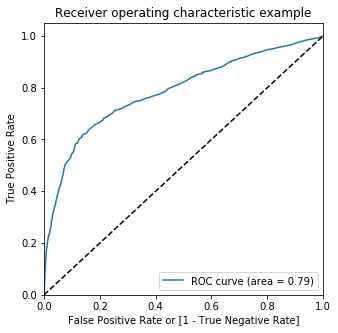

In [158]:
# Call the ROC function
draw_roc(y_train_pred_final.response, y_train_pred_final.response_prob)

The area under the curve of the ROC is 0.79 which is quite good. So we seem to have a good model. Let's also check the sensitivity and specificity tradeoff to find the optimal cutoff point.

In [159]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.response_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,prospect_id,response_prob,response,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,39341,0.986596,1,1,1,1,1,1,1,1,1,1,1
1,39337,0.986582,1,1,1,1,1,1,1,1,1,1,1
2,39326,0.986569,1,1,1,1,1,1,1,1,1,1,1
3,39327,0.986569,0,1,1,1,1,1,1,1,1,1,1
4,39259,0.986500,1,1,1,1,1,1,1,1,1,1,1


In [160]:
# Let's create a dataframe to see the values of accuracy, sensitivity, and specificity at different values of probabiity cutoffs

cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.response, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.113003  1.000000  0.000000
0.1   0.1  0.113003  1.000000  0.000000
0.2   0.2  0.285699  0.945979  0.201580
0.3   0.3  0.479276  0.860037  0.430767
0.4   0.4  0.718671  0.723757  0.718023
0.5   0.5  0.773681  0.682627  0.785281
0.6   0.6  0.835663  0.611111  0.864271
0.7   0.7  0.858763  0.546654  0.898526
0.8   0.8  0.891818  0.338551  0.962304
0.9   0.9  0.898824  0.188459  0.989325


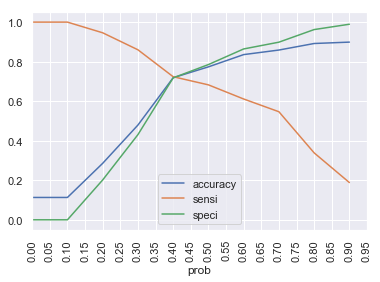

In [161]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
sns.set()
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.xticks(np.arange(0,1,0.05))
plt.xticks(rotation='vertical')
plt.show()

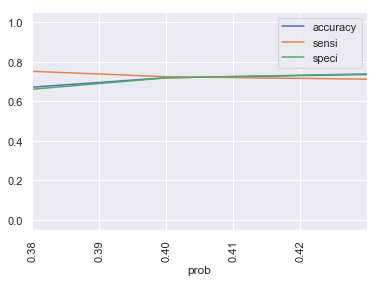

In [162]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.xticks(np.arange(0.38,0.43,0.01))
plt.xticks(rotation='vertical')
plt.xlim(0.38,0.43)
plt.show()

#### Optimal cutoff probability is 0.405.

In [163]:
#creating final prediction on train dataset
y_train_pred_final['final_train_prediction'] = y_train_pred_final.response_prob.map( lambda x: 1 if x > 0.405 else 0)
y_train_pred_final.head()

,prospect_id,response_prob,response,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_train_prediction
0,39341,0.986596,1,1,1,1,1,1,1,1,1,1,1,1
1,39337,0.986582,1,1,1,1,1,1,1,1,1,1,1,1
2,39326,0.986569,1,1,1,1,1,1,1,1,1,1,1,1
3,39327,0.986569,0,1,1,1,1,1,1,1,1,1,1,1
4,39259,0.986500,1,1,1,1,1,1,1,1,1,1,1,1


#### Evaluation matrix with optimal cutoff:

#### Train Dataset:

In [164]:
# Let's check the overall accuracy.
print('Train Accuracy:', accuracy_score(y_train_pred_final.response, y_train_pred_final.final_train_prediction))

confusion_train = confusion_matrix(y_train_pred_final.response, y_train_pred_final.final_train_prediction)
print(confusion_train)

TP = confusion_train[1,1] # true positive 
TN = confusion_train[0,0] # true negatives
FP = confusion_train[0,1] # false positives
FN = confusion_train[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print("Sensitivity:",TP / float(TP+FN))

# Let us calculate specificity
print("Specificity:", TN / float(TN+FP))

# Calculate false postive rate 
print('False poisitive rate:',FP/ float(TN+FP))

# Positive predictive value 
print ('Positive predictive power :',TP / float(TP+FP))

# Negative predictive value
print ('Negative predictive power :',TN / float(TN+ FN))

Train Accuracy: 0.720717283479588
[[18427  7146]
 [  906  2352]]
Sensitivity: 0.7219152854511971
Specificity: 0.7205646580377743
False poisitive rate: 0.2794353419622258
Positive predictive power : 0.2476310802274163
Negative predictive power : 0.9531371230538458


#### Making prediction on test dataset:

In [165]:
y_test_pred = logreg_model.predict_proba(X_test[final_cols])

In [166]:
# combining X_test prospect id and y_test_pred
y_test_pred_final = pd.DataFrame(y_test_pred[:,1],index = X_test.index).reset_index().rename(columns = {0:'response_prob'})
y_test_pred_final.head()

,prospect_id,response_prob
0,33149,0.518761
1,27586,0.391699
2,15723,0.330337
3,40350,0.949514
4,2577,0.177116


In [167]:
#sorting the dataframe
y_test_pred_final = y_test_pred_final.sort_values(by='response_prob',ascending = False)

In [168]:
y_test_pred_final = pd.merge(y_test_pred_final,y_test.reset_index(), on = 'prospect_id')
y_test_pred_final['final_test_prediction'] = y_test_pred_final.response_prob.map(lambda x : 1 if x > 0.405 else 0)
y_test_pred_final.head()

,prospect_id,response_prob,response,final_test_prediction
0,39148,0.986458,1,1
1,39154,0.986458,1,1
2,39379,0.985813,1,1
3,39228,0.985689,1,1
4,40732,0.979209,1,1


#### Evaluating the test data set:

In [169]:
# Let's check the overall accuracy.
print('Test Accuracy:', accuracy_score(y_test_pred_final.response, y_test_pred_final.final_test_prediction))

confusion_test = confusion_matrix(y_test_pred_final.response, y_test_pred_final.final_test_prediction)
print(confusion_test)

TP = confusion_test[1,1] # true positive 
TN = confusion_test[0,0] # true negatives
FP = confusion_test[0,1] # false positives
FN = confusion_test[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print("Sensitivity:",TP / float(TP+FN))

# Let us calculate specificity
print("Specificity:", TN / float(TN+FP))

# Calculate false postive rate 
print('False poisitive rate:',FP/ float(TN+FP))

# Positive predictive value 
print ('Positive predictive power :',TP / float(TP+FP))

# Negative predictive value
print ('Negative predictive power :',TN / float(TN+ FN))

Test Accuracy: 0.7202395403415068
[[7929 3046]
 [ 411  971]]
Sensitivity: 0.7026049204052098
Specificity: 0.7224601366742597
False poisitive rate: 0.2775398633257403
Positive predictive power : 0.2417226786158825
Negative predictive power : 0.9507194244604317


Definitely, there is improvement in sensitivity by using optimal prob cut- off.
Our sensitivity on train dataset is 72.19% and test is 70.26%.

#### Final model:

Because we have to find 80% of total responders, it doesn't make sense to take only train or test dataset. 
So let us combine this to form our entire dataset again.

In [170]:
#creating the complete dataset of X
total_X = pd.concat([X_train1,X_test1],axis = 0).sort_index()

#creating the complete dataset of y
total_y = pd.concat([y_train,y_test],axis = 0).sort_index()

In [171]:
#final model probability prediction
probability_pred = logreg_model.predict_proba(total_X[final_cols])

In [172]:
final_df = pd.DataFrame(probability_pred[:,1],index = total_X.index).reset_index().rename(columns = {0:'probability of response'})
final_df = final_df.sort_values(by='probability of response',ascending = False)
final_df = final_df.merge(total_y.reset_index(),on='prospect_id')
final_df['predicted response'] = final_df['probability of response'].apply(lambda x : 1 if x> 0.405 else 0)
final_df.head()

,prospect_id,probability of response,response,predicted response
0,39341,0.986596,1,1
1,39337,0.986582,1,1
2,39327,0.986569,0,1
3,39326,0.986569,1,1
4,39259,0.986500,1,1


#### Evaluation on entire dataset:

In [173]:
# Let's check the overall accuracy.
print('Accuracy of entire dataset:', accuracy_score(final_df.response, final_df['predicted response']))

cm = confusion_matrix(final_df.response, final_df['predicted response'])
print(cm)

TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print("Sensitivity:",TP / float(TP+FN))

# Let us calculate specificity
print("Specificity:", TN / float(TN+FP))

# Calculate false postive rate 
print('False poisitive rate:',FP/ float(TN+FP))

# Positive predictive value 
print ('Positive predictive power :',TP / float(TP+FP))

# Negative predictive value
print ('Negative predictive power :',TN / float(TN+ FN))

Accuracy of entire dataset: 0.7205739535787122
[[26356 10192]
 [ 1317  3323]]
Sensitivity: 0.7161637931034482
Specificity: 0.7211338513735361
False poisitive rate: 0.2788661486264638
Positive predictive power : 0.24587495375508694
Negative predictive power : 0.9524084848046833


#### Checkpoint 3:
#### Create a data frame with the variables prospect ID, actual response, predicted response, predicted probability of response, duration of the call in seconds and cost of the call:

In [174]:
final_df = pd.merge(final_df,loan_copy1.duration, on = 'prospect_id')

In [175]:
final_df.head()

,prospect_id,probability of response,response,predicted response,duration
0,39341,0.986596,1,1,101
1,39337,0.986582,1,1,136
2,39327,0.986569,0,1,344
3,39326,0.986569,1,1,248
4,39259,0.986500,1,1,215


#### Assumption:

##### Cost of call is 50 paisa per minute. [Rs 0.50 per 60 seconds]

In [176]:
#calculating cost per call
final_df['cost_per_call_in_Rs'] = ((0.50*(final_df.duration))/60)

In [177]:
final_df.head()

,prospect_id,probability of response,response,predicted response,duration,cost_per_call_in_Rs
0,39341,0.986596,1,1,101,0.841667
1,39337,0.986582,1,1,136,1.133333
2,39327,0.986569,0,1,344,2.866667
3,39326,0.986569,1,1,248,2.066667
4,39259,0.986500,1,1,215,1.791667


#### Top X% target analysis:

In [178]:
#creating a copy
decile_df = final_df[:]

In [179]:
#creating decile
decile_df['decile'] = pd.qcut(decile_df['probability of response'], 10, labels=np.arange(10, 0, -1))
decile_df.head()

,prospect_id,probability of response,response,predicted response,duration,cost_per_call_in_Rs,decile
0,39341,0.986596,1,1,101,0.841667,1
1,39337,0.986582,1,1,136,1.133333,1
2,39327,0.986569,0,1,344,2.866667,1
3,39326,0.986569,1,1,248,2.066667,1
4,39259,0.986500,1,1,215,1.791667,1


In [180]:
#finding total count per decile
lift_df = decile_df.groupby('decile')['probability of response'].count().reset_index()
lift_df

,decile,probability of response
0,10,4218
1,9,4086
2,8,4126
3,7,4063
4,6,4118
5,5,4382
6,4,3976
7,3,4139
8,2,3963
9,1,4117


In [181]:
lift_df.rename({'probability of response':'total'}, axis=1, inplace=True)

In [182]:
lift_df_pred = decile_df[decile_df['response']==1].groupby('decile')['response'].count().reset_index()

In [183]:
lift_df_final = lift_df.merge(lift_df_pred,on = 'decile')

In [184]:
lift_df_final = lift_df_final.sort_values(['decile'], ascending=False)

In [185]:
lift_df_final['cumresp'] = lift_df_final['response'].cumsum()

In [186]:
lift_df_final['gain'] = 100*(lift_df_final['cumresp']/sum(lift_df_final['response']))

In [187]:
lift_df_final['cumlift'] = lift_df_final['gain']/(lift_df_final['decile'].astype('int')*(100/10))

In [188]:
lift_df_final = lift_df_final.merge(decile_df.groupby('decile').duration.sum().reset_index(),on='decile')
lift_df_final

,decile,total,response,cumresp,gain,cumlift,duration
0,1,4117,1966,1966,42.370690,4.237069,1183069
1,2,3963,887,2853,61.487069,3.074353,1074082
2,3,4139,384,3237,69.762931,2.325431,1065006
3,4,3976,220,3457,74.504310,1.862608,959090
4,5,4382,230,3687,79.461207,1.589224,1087228
5,6,4118,262,3949,85.107759,1.418463,1073691
6,7,4063,231,4180,90.086207,1.286946,917071
7,8,4126,185,4365,94.073276,1.175916,972874
8,9,4086,128,4493,96.831897,1.075910,1021963
9,10,4218,147,4640,100.000000,1.000000,1122062


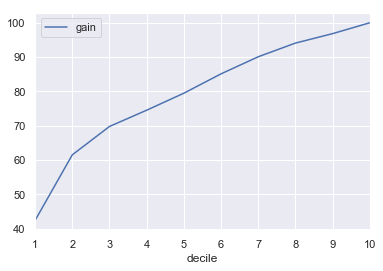

In [189]:
lift_df_final.plot.line(x='decile', y=['gain'])

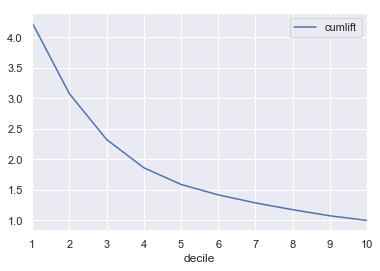

In [190]:
lift_df_final.plot.line(x='decile', y=['cumlift'])

Our per business objective we have to reach out 80% of the responders.

So if we target the people in top 5 deciles we can reach out to 79.46% (Approx 80%) of the responders(approx 24,577).
We can reach out to top 6 deciles as well, to reach exactly 80% or more than 80%(85.1%) of the responders. But it will be an extra 4118 calls.
So going ahead with 5 deciles.

#### Let us separate the target prospect(5 decile):

In [191]:
target_prospect = decile_df[(decile_df['decile'] ==1) | (decile_df['decile']  ==2) | (decile_df['decile']  ==3) | (decile_df['decile']  ==4) | (decile_df['decile']  ==5)]

In [192]:
target_prospect.head()

,prospect_id,probability of response,response,predicted response,duration,cost_per_call_in_Rs,decile
0,39341,0.986596,1,1,101,0.841667,1
1,39337,0.986582,1,1,136,1.133333,1
2,39327,0.986569,0,1,344,2.866667,1
3,39326,0.986569,1,1,248,2.066667,1
4,39259,0.986500,1,1,215,1.791667,1


#### Average call duration:

In [193]:
target_prospect['duration'].mean()

260.8968751518686

The average call duration for reaching out top 5 deciles is 261 seconds, which is about 4.35 minutes.

#### Check point 5: Lift chart:

In [194]:
# With out the model
No_of_prospects_without_model = range(1,len(loan)+1) # 41188
reponse_rate_without_model = (y.cumsum()/y.sum())*100

# with model
No_of_prospects_model = lift_df_final['total'].cumsum()
reponse_rate_with_model = lift_df_final['gain']

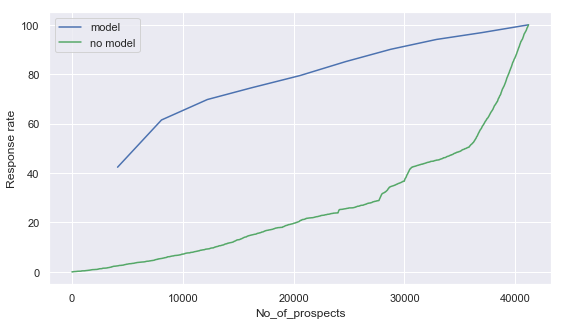

In [195]:
plt.figure(figsize= (9,5))
plt.plot(No_of_prospects_model,reponse_rate_with_model,'b',label = 'model')
plt.plot(No_of_prospects_without_model,reponse_rate_without_model,'G',label = 'no model')
plt.legend()
plt.xlabel('No_of_prospects')
plt.ylabel('Response rate')
plt.show()

We clearly see that with 20000 prospects we used to get 20% response rate. But with the influence of the model, we get around 80% of response rate.

#### Cost of acquisition:

#### 1. Assuming Cost for each call will be cost per minute*duration (As per TA verified answer in discussion forum)

In [196]:
# cost of acquiring 80% of customers
with_model_cost = round(target_prospect['cost_per_call_in_Rs'].sum(),2)
print('cost of acquiring 80% of customers(in rupees) is',round(target_prospect['cost_per_call_in_Rs'].sum(),2))

cost of acquiring 80% of customers(in rupees) is 44737.29


In [197]:
# cost of contacting all the 41k customers
with_out_model = round(decile_df['cost_per_call_in_Rs'].sum(),2)
print('cost of contacting all the 41k customers(in rupess) is', round(decile_df['cost_per_call_in_Rs'].sum(),2))

cost of contacting all the 41k customers(in rupess) is 87301.13


In [198]:
cost_saved = (with_out_model- with_model_cost)
cost_saved

42563.840000000004

As per business objective we are looking for 80% of the responders-
    This means we are only required to contact top 5 deciles, which turns out to be 24,577.
    And cost for acquiring this 80% of customer is 44737.29.
    So by using the logistic regression model we save 42,563 rupees which is approximately 49% savings.

#### 2. Assuming cost = 1*number of contacts made in the current campaign(As given in problem statement)

In [199]:
lift_df_final_5decile = lift_df_final[lift_df_final.decile >= 5]

In [200]:
#number of contacts to make for acquiring 80% customer
with_model_contacts = lift_df_final_5decile['total'].sum()
with_model_contacts

20577

So the cost of obtaining 80% contacts is 20,577.

In [201]:
#number of contacts without model
without_model_contacts = lift_df_final['total'].sum()
without_model_contacts 

41188

So the cost of contacting all 41k customers is 41,188.

In [202]:
cost_saved = (without_model_contacts- with_model_contacts)
cost_saved

20611

So with this assumption if we use model, we save around 20,611 for acquiring 80% of prospectors which is approx. 50% of savings.